NMF vs LDA Analysis with American Presidents' Inauguration Speeches 

In [61]:
!python -m pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
# All Imports
import pandas as pd
import numpy as np
import re,string
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from operator import itemgetter
import matplotlib.pyplot as plt 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


STEP 1 : Downloading data and importing it into a Dataframe.

Data Downloaded From - https://www.kaggle.com/datasets/adhok93/presidentialaddress

In [63]:
raw_data_df = pd.read_csv('/content/drive/MyDrive/inaug_speeches.csv', encoding='cp1252')
pd.set_option('display.max_colwidth', 150)
raw_data_df.head()

,Unnamed: 0,Name,Inaugural Address,Date,text
0,4,George Washington,First Inaugural Address,"Thursday, April 30, 1789",Fellow-Citizens of the Senate and of the House of Representatives: AMONG the vicissitudes incident to life no event could have fille...
1,5,George Washington,Second Inaugural Address,"Monday, March 4, 1793",Fellow Citizens: I AM again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occas...
2,6,John Adams,Inaugural Address,"Saturday, March 4, 1797","WHEN it was first perceived, in early times, that no middle course for America remained between unlimited submission to a foreign le..."
3,7,Thomas Jefferson,First Inaugural Address,"Wednesday, March 4, 1801","Friends and Fellow-Citizens: CALLED upon to undertake the duties of the first executive office of our country, I avail myself of th..."
4,8,Thomas Jefferson,Second Inaugural Address,"Monday, March 4, 1805","PROCEEDING, fellow-citizens, to that qualification which the Constitution requires before my entrance on the charge again conferred ..."


STEP 2 : Not all presidents had more than 1 terms , hence we are only considering the 1st inaugural address

In [64]:
display(raw_data_df[['Name','Inaugural Address']])

,Name,Inaugural Address
0,George Washington,First Inaugural Address
1,George Washington,Second Inaugural Address
2,John Adams,Inaugural Address
3,Thomas Jefferson,First Inaugural Address
4,Thomas Jefferson,Second Inaugural Address
5,James Madison,First Inaugural Address
6,James Madison,Second Inaugural Address
7,James Monroe,First Inaugural Address
8,James Monroe,Second Inaugural Address
9,John Quincy Adams,Inaugural Address


In [65]:
display(raw_data_df.groupby(['Name']).size().reset_index(name='counts'))

,Name,counts
0,Abraham Lincoln,2
1,Andrew Jackson,2
2,Barack Obama,2
3,Benjamin Harrison,1
4,Bill Clinton,2
5,Calvin Coolidge,1
6,Donald J. Trump,1
7,Dwight D. Eisenhower,2
8,Franklin D. Roosevelt,4
9,Franklin Pierce,1


Limiting the number of columns to 2 i.e President's Name and their speech text

In [66]:
raw_data_df=raw_data_df[['Name',"text"]]
raw_data_df = raw_data_df.set_index('Name')
raw_data_df.head()

,text
Name,
George Washington,Fellow-Citizens of the Senate and of the House of Representatives: AMONG the vicissitudes incident to life no event could have fille...
George Washington,Fellow Citizens: I AM again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occas...
John Adams,"WHEN it was first perceived, in early times, that no middle course for America remained between unlimited submission to a foreign le..."
Thomas Jefferson,"Friends and Fellow-Citizens: CALLED upon to undertake the duties of the first executive office of our country, I avail myself of th..."
Thomas Jefferson,"PROCEEDING, fellow-citizens, to that qualification which the Constitution requires before my entrance on the charge again conferred ..."


Data Cleaning - 

In [67]:

def clean_raw_data(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    
    return text
round1 = lambda x: clean_raw_data(x)
# Clean Speech Text
raw_data_df["text"] = raw_data_df["text"].apply(round1)
# Visually Inspect
raw_data_df.head()

,text
Name,
George Washington,fellow citizens of the senate and of the house of representatives among the vicissitudes incident to life no event could have fille...
George Washington,fellow citizens i am again called upon by the voice of my country to execute the functions of its chief magistrate when the occas...
John Adams,when it was first perceived in early times that no middle course for america remained between unlimited submission to a foreign le...
Thomas Jefferson,friends and fellow citizens called upon to undertake the duties of the first executive office of our country i avail myself of th...
Thomas Jefferson,proceeding fellow citizens to that qualification which the constitution requires before my entrance on the charge again conferred ...


In [68]:
stop_words = nltk.corpus.stopwords.words('english')
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [69]:

def tokenize_words(txt):
  tokenized = word_tokenize(txt)
  return tokenized

def remove_stopwords(tokenized_txt):
  cleaned_text_array = [word for word in tokenized_txt if word not in stop_words]
  return cleaned_text_array

def word_lemmatizer(tokenized_text_without_stopwords):
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in tokenized_text_without_stopwords]
  return ' '.join(lemmatized)

raw_data_df['tokenized_text']=raw_data_df['text'].apply(tokenize_words)

raw_data_df['tokenized_text_without_stopwords'] = raw_data_df['tokenized_text'].apply(lambda x: remove_stopwords(x))

raw_data_df['lemmatized_tok_txt_wo_stopwords'] = raw_data_df['tokenized_text_without_stopwords'].apply(lambda x: word_lemmatizer(x))

raw_data_df.head()

,text,tokenized_text,tokenized_text_without_stopwords,lemmatized_tok_txt_wo_stopwords
Name,,,,
George Washington,fellow citizens of the senate and of the house of representatives among the vicissitudes incident to life no event could have fille...,"[fellow, citizens, of, the, senate, and, of, the, house, of, representatives, among, the, vicissitudes, incident, to, life, no, event, could, have...","[fellow, citizens, senate, house, representatives, among, vicissitudes, incident, life, event, could, filled, greater, anxieties, notification, tr...",fellow citizen senate house representative among vicissitude incident life event could filled greater anxiety notification transmitted order recei...
George Washington,fellow citizens i am again called upon by the voice of my country to execute the functions of its chief magistrate when the occas...,"[fellow, citizens, i, am, again, called, upon, by, the, voice, of, my, country, to, execute, the, functions, of, its, chief, magistrate, when, the...","[fellow, citizens, called, upon, voice, country, execute, functions, chief, magistrate, occasion, proper, shall, arrive, shall, endeavor, express,...",fellow citizen called upon voice country execute function chief magistrate occasion proper shall arrive shall endeavor express high sense entertai...
John Adams,when it was first perceived in early times that no middle course for america remained between unlimited submission to a foreign le...,"[when, it, was, first, perceived, in, early, times, that, no, middle, course, for, america, remained, between, unlimited, submission, to, a, forei...","[first, perceived, early, times, middle, course, america, remained, unlimited, submission, foreign, legislature, total, independence, claims, men,...",first perceived early time middle course america remained unlimited submission foreign legislature total independence claim men reflection le appr...
Thomas Jefferson,friends and fellow citizens called upon to undertake the duties of the first executive office of our country i avail myself of th...,"[friends, and, fellow, citizens, called, upon, to, undertake, the, duties, of, the, first, executive, office, of, our, country, i, avail, myself, ...","[friends, fellow, citizens, called, upon, undertake, duties, first, executive, office, country, avail, presence, portion, fellow, citizens, assemb...",friend fellow citizen called upon undertake duty first executive office country avail presence portion fellow citizen assembled express grateful t...
Thomas Jefferson,proceeding fellow citizens to that qualification which the constitution requires before my entrance on the charge again conferred ...,"[proceeding, fellow, citizens, to, that, qualification, which, the, constitution, requires, before, my, entrance, on, the, charge, again, conferre...","[proceeding, fellow, citizens, qualification, constitution, requires, entrance, charge, conferred, duty, express, deep, sense, entertain, new, pro...",proceeding fellow citizen qualification constitution requires entrance charge conferred duty express deep sense entertain new proof confidence fel...


In [71]:
additional_stop_words = ["fellow","america", 'today', 'thing']
stop_words_aggr = text.ENGLISH_STOP_WORDS.union(additional_stop_words)

tfidf = TfidfVectorizer(stop_words=stop_words_aggr, ngram_range = (1,1), max_df = .8, min_df = .01)
tfidf_transformed = tfidf.fit_transform(raw_data_df.lemmatized_tok_txt_wo_stopwords) #We are fitting and transforming the speech words to a TFIDF Matrix

data_with_words_as_columns = pd.DataFrame(tfidf_transformed.toarray(), columns=tfidf.get_feature_names()) 
data_with_words_as_columns.index = raw_data_df.index #To include president names in the o/p we are setting Presidents name as Index

data_with_words_as_columns.head()



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,abandon,abandoned,abandonment,abate,abdicated,abeyance,abhorring,abide,abiding,ability,...,yorktown,young,younger,youngest,youth,youthful,zeal,zealous,zealously,zone
Name,,,,,,,,,,,,,,,,,,,,,
George Washington,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
George Washington,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
John Adams,0.000000,0.033371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.029253,0.0,0.0,0.0
Thomas Jefferson,0.038482,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.036970,0.0,0.0,0.0
Thomas Jefferson,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090101,0.0,0.0,0.0


In [72]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
  for ix, topic in enumerate(model.components_):
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", ix)
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [73]:
nmf_model = NMF(5)
nmf_topic = nmf_model.fit_transform(data_with_words_as_columns)
display_topics(nmf_model, tfidf.get_feature_names(), 5)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,



Topic  0
union, constitution, public, duty, principle

Topic  1
let, freedom, century, work, child

Topic  2
law, public, congress, constitution, business

Topic  3
freedom, democracy, peace, know, economic

Topic  4
war, offense, british, woe, savage


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Metrics

In [74]:

processed_texts = raw_data_df['lemmatized_tok_txt_wo_stopwords'].apply(lambda x : x.split(' '))
# Create hashmap between words and integer ids
dictionary = Dictionary(processed_texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3,
                          no_above=0.9,
                          keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Create a list of the topic numbers we want to try in increasing order
topic_numbers = list(np.arange(5, 70 + 1, 5))

# Running the nmf model and to get the coherence score for each number of topics
coherence_scores = []

for nums in topic_numbers:
    nmf = Nmf(
        corpus=corpus,
        num_topics=nums,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    coherence_model = CoherenceModel(
            model=nmf,
            texts=processed_texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        
    coherence_scores.append(round(coherence_model.get_coherence(), 5))
  
# Get the number of topics with the highest coherence score
coherence_scores_tup = list(zip(topic_numbers, coherence_scores))
best_topics_number = sorted(coherence_scores_tup, key=itemgetter(1), reverse=True)[0][0]


[(5, 0.32132), (10, 0.35144), (15, 0.35333), (20, 0.33156), (25, 0.34373), (30, 0.34559), (35, 0.34233), (40, 0.3413), (45, 0.33721), (50, 0.33861), (55, 0.33561), (60, 0.33406), (65, 0.33192), (70, 0.32627)]


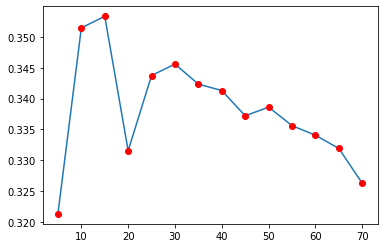


 The Best number of topics for maximum coherence score -  15


In [75]:
print(coherence_scores_tup)
x_val = [x[0] for x in coherence_scores_tup]
y_val = [x[1] for x in coherence_scores_tup]

plt.plot(x_val,y_val)
plt.plot(x_val,y_val,'or')
plt.show()

print("\n The Best number of topics for maximum coherence score - ",best_topics_number)